<a href="https://colab.research.google.com/github/y437li/reinforce/blob/master/%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0DDPG%E6%A1%88%E4%BE%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**前导**
强化学习案例，在这里我们使用的DDPG算法
DDPG是一个隐式（model Free）的算法的异策略（off policy）算法
DDPG是加强版本的Actor-critict算法，
结合了DPG（determinstic policy gredient）和DQN（Deep Q network），根据根据DQN里的经验(experience relay)和慢学习(slow learning)network,来对DPG的在连续动作进行指导。

此案例仅限于DDPG算法的实现，不包括环境的设计
**相关论文**

[DDPG](https://arxiv.org/pdf/1509.02971.pdf)

[DQN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

[DPG](http://proceedings.mlr.press/v32/silver14.pdf)

[Tensoflow信息](https://www.tensorflow.org/api_docs/python/tf)



最基础的Actor-Critic由两个神经网络组成：

Actor（演员）network：负责建议下一步的行为

Critic（评论员）network：我们用这个网络来判断在摸个状态（state）下的某个行为（action）是好是坏

**DDPG加入两个目标网络（target）,这样做有两个好处**：

1.**因为它增加了训练的稳定性**。简而言之，我们是从估计的目标（estimate target）中学习，而目标网络（target）的更新速度很慢，因此保持了我们估计目标的稳定性。

从概念上讲，这就好比说："我有了一个如何下好这个棋的想法（estimate target），我要试一试，直到找到更好的办法（在更新目标网络）"，而不是说："我要在每一步棋后重新学习如何下好这整个棋局（直接更新目标网络）"

2.他用到了**经验回放**我们存储了tuple的列表（state，action，reward，next_state），我们不是只从最近的经验中学习，而是从迄今为止积累的所有经验中抽样学习。


##**案例问题**

倒摆摆起问题是控制文献中的一个经典问题。在这个问题的版本中，摆杆从一个随机的位置开始，目标是我们控制把它摆起来，并使它保持直立。

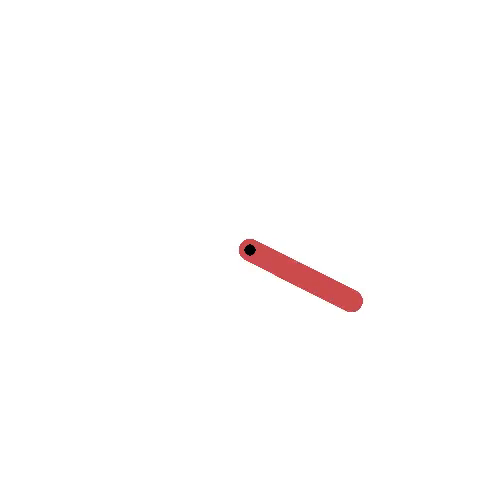

## 如何实现

第一步安装软件包

In [1]:
##此强化学习案例基于python，运用了一下python的软件包
##训练环境软件包
import gym
##神经网络架构包
import tensorflow as tf
##神经网络架构包的子包
from tensorflow.keras import layers
##矩阵包
import numpy as np
##数据展示包
import matplotlib.pyplot as plt
##视频包
import imageio
import pyglet

我们使用OpenAIGym来创建环境
[OpenAIGym](http://gym.openai.com/)

In [2]:
##问题类型
problem = "Pendulum-v0"
#用gym包里的make方程选取模拟环境,设定环境
#奖励函数，都被设定在了env里
env = gym.make(problem)

#定义状态（观测）矩阵
num_states = env.observation_space.shape[0]
print("Size of （状态空间）State Space ->  {}".format(num_states))
#定义行为矩阵
num_actions = env.action_space.shape[0]
print("Size of (动作空间) Action Space ->  {}".format(num_actions))
#动作行为，行为边界为2，和-2
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of （状态空间）State Space ->  3
Size of (动作空间) Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [3]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

In [4]:
env.observation_space

Box(-8.0, 8.0, (3,), float32)

为了实现Actor网络更好的探索，我们使用了噪声扰动，特别是一个（奥恩斯坦-乌伦贝克过程）Ornstein-Uhlenbeck过程来产生噪声，如文中所述。它从一个相关的正态分布中采样噪声。

我们通过在python中定义一个class来实现

In [5]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

我们通过定义一个buffer class 来实现经验回放（Experience Replay）

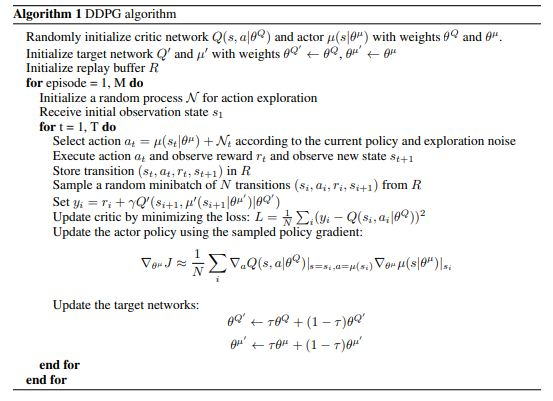

批评者损失(critic loss)--y的MSE（平均平方误差）-Q(s，a)，其中y是目标网络(traget network)看到的预期收益，Q(s，a)是批评者网络预测的行动值。y是批评者模型试图达到的一个变化的目标，我们通过缓慢更新目标模型使这个目标稳定。

行动者损失（actural loss) -这是利用批评者网络给出的行动值的平均值计算出来的。我们寻求这个量的最大化。

因此，我们更新Actor网络，使其产生的动作在给定状态下得到Critic所看到的预测值最大。

In [6]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # 存储回放经验最大储存量
        self.buffer_capacity = buffer_capacity
        #每一次训练多少经验片段
        self.batch_size = batch_size

        #告知系统我们已经储存了多少个buffer，从零开始
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        #我们将list的经验回放转化成矩阵的格式
        #状态矩阵
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        #动作矩阵
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        #奖励矩阵
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        #下一个状态矩阵
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    #将（状态，动作，回报，下一个状态）当做一个片段
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        #如果我们的buffer_capacity被超过了
        #我们从底端开始更替
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    ###更新方程###
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.

        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            #批评者损失
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
        ##计算critic
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        ##选择critic的optimizer，并进行更新
        ##apply_gradient是一个梯度修剪方程，避免训练梯度爆炸和消失问题
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        ##选择actor的optimizer，并进行更新
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        # 选取片段的值
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        # 随机选取片段
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        #转化成tensor格式
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        ##定义的更新方程
        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
#更新目标神经网络的权重
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

这里我们定义了演员和评论家网络。这些是基本的ReLU激活的Dense模型。

注意：我们需要将 Actor 最后一层的初始化介于 -0.003 和 0.003 之间，因为这可以防止我们在初始阶段得到 1 或 -1 的输出值，这会将我们的梯度压制为零，因为我们使用 tanh 激活

In [7]:
#演员神经网络（策略选择函数）
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    #神经网络的结构
    #layer层
    #Dense全连接层
    #activation function激活函数
    #256 有256个神经元
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

#评论神经网络（动作价值状态函数）
def get_critic():
    # State as input（状态输入）
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input（动作输入）
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    # 在结合之前，分别通过不同的隐藏层
    concat = layers.Concatenate()([state_out, action_out])
    #在通过一个网络来产生最后的结论
    #256，32，16是每层神经元的数量
    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

policy()会返回一个从我们的Actor网络中取样的动作，再加上一些噪音进行探索。

In [8]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

##**神经网络训练的超参数**

In [9]:
#定义的奥恩斯坦-乌伦贝克过程的方差
std_dev = 0.2
#产生噪音
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
#生成神经网络
actor_model = get_actor()
critic_model = get_critic()
#生成目标神经网络
target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
# 目标神经网络和学习神经网络权重相同
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
#设置神经网络的学习强度
critic_lr = 0.002
actor_lr = 0.001
#加入optimizer
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
#总共训练多少个回合
total_episodes = 200
# Discount factor for future rewards
#回报折现率
gamma = 0.99
# Used to update target networks
#目标网络的更新频率
tau = 0.005
##这里设置buffer的储存量为50000，训练batch是64
buffer = Buffer(50000, 64)

现在，我们实现我们的主训练循环，并在情节上迭代。我们使用policy()对动作进行采样，并在每个时间步骤使用learn()进行训练，同时以tau的速度更新Target网络。

Episode * 0 * Avg Reward is ==> -1513.161040962729
Episode * 1 * Avg Reward is ==> -1626.7125054878452
Episode * 2 * Avg Reward is ==> -1437.7880599576083
Episode * 3 * Avg Reward is ==> -1351.574019745206
Episode * 4 * Avg Reward is ==> -1325.967125842029
Episode * 5 * Avg Reward is ==> -1340.693254666471
Episode * 6 * Avg Reward is ==> -1363.7678006111685
Episode * 7 * Avg Reward is ==> -1381.9578838641996
Episode * 8 * Avg Reward is ==> -1387.9314297670853
Episode * 9 * Avg Reward is ==> -1367.6335770983262
Episode * 10 * Avg Reward is ==> -1337.5165725881443
Episode * 11 * Avg Reward is ==> -1299.717756822152
Episode * 12 * Avg Reward is ==> -1276.1013092976957
Episode * 13 * Avg Reward is ==> -1239.2171624144116
Episode * 14 * Avg Reward is ==> -1191.3827531874554
Episode * 15 * Avg Reward is ==> -1141.1105027948358
Episode * 16 * Avg Reward is ==> -1103.238146722925
Episode * 17 * Avg Reward is ==> -1056.0241396404629
Episode * 18 * Avg Reward is ==> -1022.952721720098
Episode * 

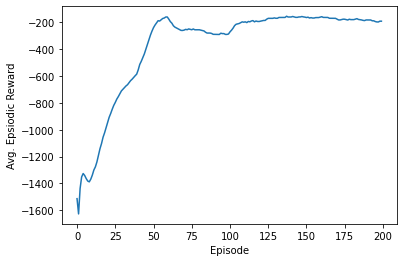

In [10]:
# To store reward history of each episode
#每个回合跑完的奖励历史
ep_reward_list = []
# To store average reward history of last few episodes
#记录过去几个回合的平均回报
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    # 计算最近40个的回合的平均回报
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
# 画出平均的回合回报
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [16]:
# Save the weights
#储存训练好的神经网络
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")

In [17]:
##目标神经网络结构示意图
target_actor.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
_________________________________________________________________
tf.math.multiply_1 (TFOpLamb (None, 1)                 0         
Total params: 67,073
Trainable params: 67,073
Non-trainable params: 0
_________________________________________________________________


**放入虚拟环境中**

In [18]:
#最终的policy基于目标表演网络target_actor
def final_policy(state):
    sampled_actions = tf.squeeze(target_actor(state))

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

平均奖励:-2.716019147353259


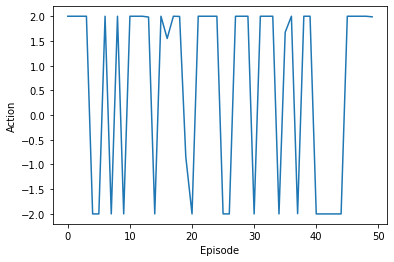

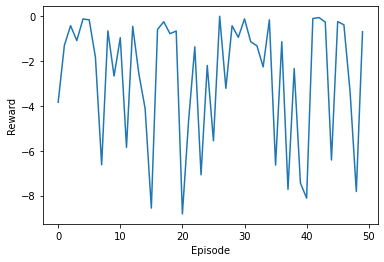

In [25]:
#基于最后目标函数的表现
total = 0
nepisode = 50
action_list = []
reward_list = []
for i_episode in range(nepisode):
    observation = env.reset()
    observation=tf.expand_dims(tf.convert_to_tensor(observation), 0)
    action = final_policy(observation)
    action_list.append(action)
    observation, reward, done, info = env.step(action)
    reward_list.append(reward)
    total += reward
print("平均奖励:{}".format(total/nepisode))
# Plotting graph
# 画出动作,奖励
plt.plot(action_list)
plt.xlabel("Episode")
plt.ylabel("Action")
plt.show()
plt.plot(reward_list)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

平均奖励:-3.743465522471439


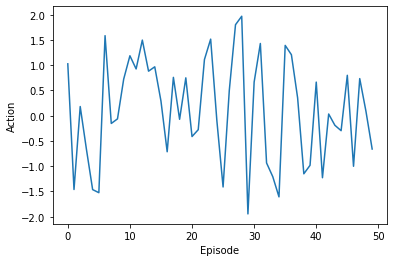

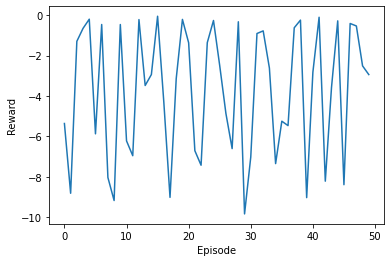

In [27]:
#随机动作
total_2 = 0
nepisode_2 = 50
action_list_2 = []
reward_list_2 = []
for i_episode in range(nepisode_2):
    observation_2 = env.reset()
    action_2 = env.action_space.sample()
    action_list_2.append(action_2)
    observation_2, reward_2, done, info = env.step(action)
    reward_list_2.append(reward_2)
    total_2 += reward_2
    #print("观测：{}".format(observation_2),"奖励:{}".format(reward_2))
print("平均奖励:{}".format(total_2/nepisode))
# Plotting graph
# 画出动作,奖励
plt.plot(action_list_2)
plt.xlabel("Episode")
plt.ylabel("Action")
plt.show()
plt.plot(reward_list_2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()